### Double DQN

In [2]:
import random
import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm


class Qnet(torch.nn.Module):
    ''' Âè™Êúâ‰∏ÄÂ±ÇÈöêËóèÂ±ÇÁöÑQÁΩëÁªú '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [20]:
class DQN:
    ''' DQNÁÆóÊ≥ï,ÂåÖÊã¨Double DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device
    
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()
    
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # QÂÄº
        # ‰∏ã‰∏™Áä∂ÊÄÅÁöÑÊúÄÂ§ßQÂÄº
        if self.dqn_type == 'VanillaDQN':
            #ÊôÆÈÄöDQNÁöÑÊÉÖÂÜµ
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1,1) #[0] ÂèñÊúÄÂ§ßÂÄº
        else:
            max_action = self.q_net(next_states).max(1)[1].view(-1,1) #[1] ÂèñÊúÄÂ§ßÂÄºÁöÑÁ¥¢Âºï
            #‰πüÂèØ‰ª•ËøôÊ†∑ÂÜô 
            #max_action = self.q_net(next_state).argmax(1).view(-1,1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action) #Âª∂Áª¥Â∫¶‰∏ÄÂèñÁ¥¢Âºï

        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # Êõ¥Êñ∞ÁõÆÊ†áÁΩëÁªú
        self.count += 1

In [30]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 100
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
print(env.observation_space)
print(env.action_space)
action_dim = 11  # Â∞ÜËøûÁª≠Âä®‰ΩúÂàÜÊàê11‰∏™Á¶ªÊï£Âä®‰Ωú

def dis_to_con(discrete_action, env, action_dim):
    action_lowbound = env.action_space.low[0]  #box Á±ªÂûã‰∏çÂèØ‰ª•Áõ¥Êé•Á¥¢Âºï
    action_upperbound = env.action_space.high[0]
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upperbound - action_lowbound)

print(dis_to_con(0,env,action_dim))

Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Box(-2.0, 2.0, (1,), float32)
-2.0


In [31]:
import collections

class ReplayBuffer:
    '''
    ÁªèÈ™åÂõûÊîæÊ±†
    1. ‰øùËØÅÊï∞ÊçÆÁöÑÁã¨Á´ãÂêåÂàÜÂ∏É
    2. ÊèêÂçáÊ†∑Êú¨Âà©Áî®ÊïàÁéá
    '''
    def __init__(self,capacity):
        self.buffer = collections.deque(maxlen=capacity) #ÂàùÂßãÂåñ‰∏Ä‰∏™ÂèåÁ´ØÈòüÂàó.

    def add(self,state,action,reward,next_state,done):
        #Â∞ÜÊï∞ÊçÆÂä†ÂÖ•buffer
        self.buffer.append((state,action,reward,next_state,done))

    def sample(self,batch_size):
        # obtain sample form buffer, size is batch_size
        transition = random.sample(self.buffer,batch_size)
        #ÊåâÂàóËß£ÂåÖ, state Êï∞ÊçÆÈÄöÂ∏∏ÊòØÂ§öÁª¥Êï∞ÊçÆ
        state_tuple, action_tuple, reward_tuple,next_state_tuple, done_tuple = zip(*transition)
        return np.array(state_tuple), action_tuple, reward_tuple, np.array(next_state_tuple), done_tuple

    def size(self):
        return len(self.buffer)

In [32]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state,_ = env.reset(seed=0)
                done = False
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # Âπ≥ÊªëÂ§ÑÁêÜ
                    max_q_value_list.append(max_q_value)  # ‰øùÂ≠òÊØè‰∏™Áä∂ÊÄÅÁöÑÊúÄÂ§ßQÂÄº
                    action_continuous = dis_to_con(action, env,agent.action_dim)
                    next_state, reward, terminated, truncated, _ = env.step([action_continuous])
                    done = terminated or truncated
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':'%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':'%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list

Iteration 0:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration 9: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:13<00:00,  1.46it/s, episode=200, return=-127.701]


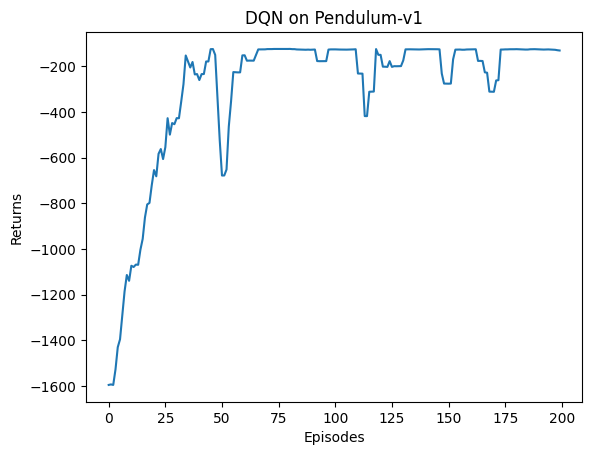

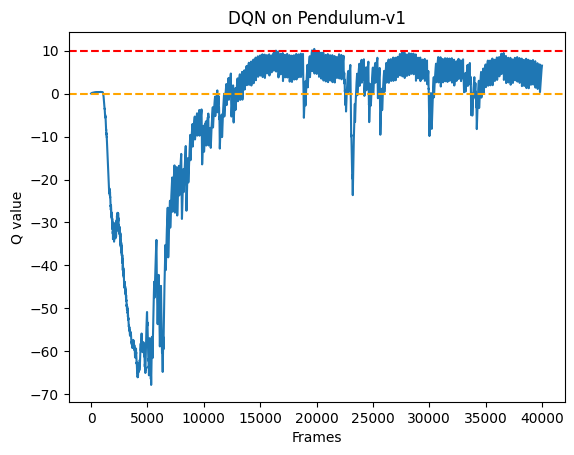

In [33]:
random.seed(0)
np.random.seed(0)

torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

Iteration 9: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:15<00:00,  1.32it/s, episode=200, return=-373.154]


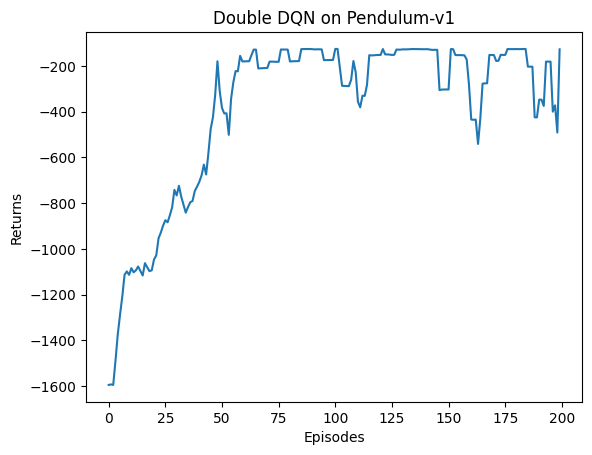

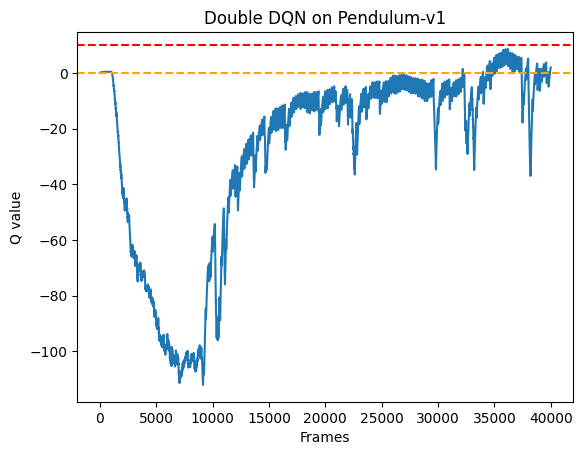

In [34]:
random.seed(0)
np.random.seed(0)

torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

### Dueling DQN

In [35]:
class VAnet(torch.nn.Module):
    ''' Âè™Êúâ‰∏Ä‰∏™ÈöêËóèÂ±ÇÁöÑAÁΩëÁªúÂíåVÁΩëÁªú '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet,self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1,1)
        return Q   

In [36]:
class DQN:
    ''' DQNÁÆóÊ≥ï,ÂåÖÊã¨Double DQNÂíåDueling DQN '''
    def __init__(self,state_dim,hidden_dim,action_dim,learning_rate,gamma,epsilon,
                 target_update,device,dqn_type='VanillaDQN'):
        self.action_dim = action_dim

        if dqn_type == 'DuelingDQN':  # Dueling DQNÈááÂèñ‰∏ç‰∏ÄÊ†∑ÁöÑÁΩëÁªúÊ°ÜÊû∂
            self.q_net = VAnet(state_dim, hidden_dim,self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,self.action_dim).to(device)

        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1


Iteration 9: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:24<00:00,  1.20s/it, episode=200, return=-229.942]


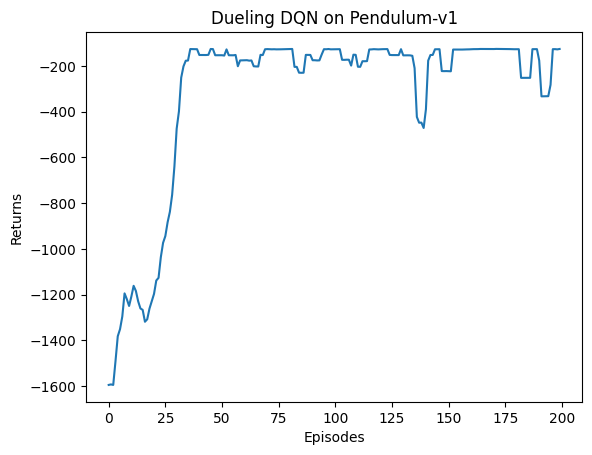

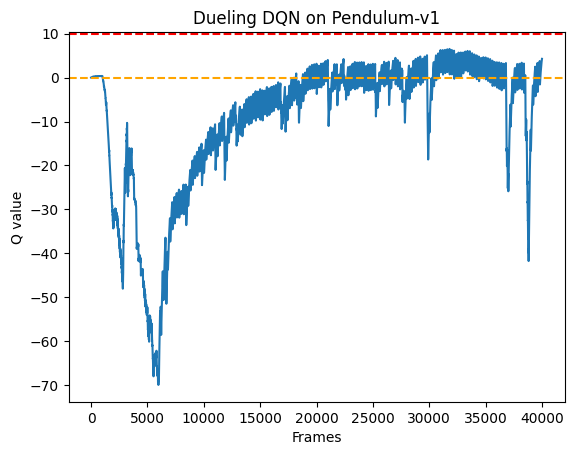

In [37]:
random.seed(0)
np.random.seed(0)

torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,target_update, device, 'DuelingDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,replay_buffer, minimal_size,batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

### Â∞ùËØïÊÄªÁªì‰ªäÂ§©ÊâÄÂ≠¶
#### 1. ‰∏∫‰ªÄ‰πàË¶ÅÊîπËøõDQN?
1. **DQNÁöÑÈ´ò‰º∞ÈóÆÈ¢ò**
   ‚úÖ Ê†∏ÂøÉÂéüÂõ†ÔºöDQN‰ΩøÁî®`max(Q)`‰ºöÁ≥ªÁªüÊÄßÈ´ò‰º∞Âä®‰Ωú‰ª∑ÂÄºÂáΩÊï∞ÔºàMaximization BiasÔºâ„ÄÇ
   üîç Ë°•ÂÖÖÊú∫Âà∂Ôºö
   - Ë¥ùÂ∞îÊõºÊñπÁ®ã‰∏≠ÁöÑÊúÄÂ§ßÊìç‰Ωú‰ºöÊîæÂ§ß‰º∞ËÆ°ËØØÂ∑ÆÔºàÂ¶ÇÂô™Â£∞ÊàñËøë‰ººËØØÂ∑ÆÔºâ„ÄÇ
   - È´ò‰º∞‰ºöÂØºËá¥Á≠ñÁï•ÂÅèÂêëÈ´òÈ£éÈô©Âä®‰ΩúÔºåÂú®ÈÉ®ÂàÜÂú∫ÊôØÔºàÂ¶ÇÁ®ÄÁñèÂ•ñÂä±Ôºâ‰∏≠Â§±Êïà„ÄÇ

2. **DQNÁöÑÊõ¥Êñ∞ÊïàÁéáÈóÆÈ¢ò**
   ‚úÖ ‰Ω†ÁöÑËßÇÁÇπÔºö
   - DQNÊØèÊ¨°Êõ¥Êñ∞‰ªÖÂΩ±ÂìçÂçï‰∏™Âä®‰ΩúÁöÑQÂÄºÔºåDueling DQNÈÄöËøáÁä∂ÊÄÅ‰ª∑ÂÄºÂáΩÊï∞VÂêåÊó∂ÂΩ±ÂìçËØ•Áä∂ÊÄÅ‰∏ãÊâÄÊúâÂä®‰ΩúÁöÑQÂÄº„ÄÇ
   üîç Ë°•ÂÖÖËß£ÈáäÔºö
   - Dueling DQNÁöÑÂàÜËß£ÂÖ¨ÂºèÔºö
   
$$

     Q(s,a) = V(s) + \left( A(s,a) - \frac{1}{|A|} \sum_{a'} A(s,a') \right)
   
$$

   - Áä∂ÊÄÅ‰ª∑ÂÄºVÁöÑÊõ¥Êñ∞‰ºöÈó¥Êé•‰øÆÊ≠£ÊâÄÊúâÂä®‰ΩúÁöÑQÂÄºÔºåÊèêÂçáÊï∞ÊçÆÊïàÁéá„ÄÇ

3. **Áä∂ÊÄÅ‰ª∑ÂÄºÁöÑÈáçË¶ÅÊÄß**
   ‚úÖ ‰Ω†ÁöÑËßÇÁÇπÔºö
   - Êüê‰∫õÂú∫ÊôØ‰∏≠ÔºåAgentÊõ¥ÂÖ≥ÂøÉÁä∂ÊÄÅÁöÑÊï¥‰Ωì‰ª∑ÂÄºÔºàÂ¶ÇÈù†ËøëÁõÆÊ†áÊó∂ÁöÑV(s)ÔºâÔºåËÄåÈùûÂçï‰∏™Âä®‰ΩúÁöÑ‰ºòÂäøÔºàA(s,a)Ôºâ„ÄÇ
   üîç ÂÖ∏ÂûãÂú∫ÊôØÔºö
   - Ëø∑ÂÆ´Âá∫Âè£ÈôÑËøëÁöÑÁä∂ÊÄÅ‰ª∑ÂÄºÊõ¥ÈáçË¶ÅÔºåÂä®‰ΩúÈÄâÊã©ÂØπÁªìÊûúÂΩ±ÂìçËæÉÂ∞è„ÄÇ

---

#### 2. ‰∏§ÁßçÊîπËøõÁÆóÊ≥ï
##### 2.1 Double DQN
‚úÖ ‰Ω†ÁöÑÊ†∏ÂøÉÊèèËø∞Ôºö
- **Âä®‰ΩúÈÄâÊã©‰∏éÂÄºËØÑ‰º∞Ëß£ËÄ¶**ÔºöÂú®Á∫øÁΩëÁªúÈÄâÂä®‰ΩúÔºà`argmax Q_online`ÔºâÔºåÁõÆÊ†áÁΩëÁªúËØÑ‰º∞QÂÄºÔºà`Q_target`Ôºâ„ÄÇ
üîç Ë°•ÂÖÖÁªÜËäÇÔºö
- **ÂèÇÊï∞Êõ¥Êñ∞Êú∫Âà∂**Ôºö
  - ÁõÆÊ†áÁΩëÁªúÈÄöËøáÁ°¨Êõ¥Êñ∞ÔºàÂÆöÊúüÂ§çÂà∂ÔºâÊàñËΩØÊõ¥Êñ∞ÔºàÂ¶ÇPolyakÂπ≥ÂùáÔºâ‰∏éÂú®Á∫øÁΩëÁªúÂêåÊ≠•„ÄÇ
- **Êï∞Â≠¶ËØÅÊòé**Ôºö
  - Ëß£ËÄ¶ÂêéÈ´ò‰º∞ÂπÖÂ∫¶Èôç‰ΩéÁ∫¶50%ÔºàËßÅHasselt et al., 2015Ôºâ„ÄÇ

##### 2.2 Dueling DQN
‚úÖ ‰Ω†ÁöÑÊ†∏ÂøÉÊèèËø∞Ôºö
- **QÂÄºÂàÜËß£**ÔºöÂ∞ÜQÂáΩÊï∞ÂàÜËß£‰∏∫Áä∂ÊÄÅ‰ª∑ÂÄºV(s)Âíå‰ºòÂäøÂáΩÊï∞A(s,a)„ÄÇ
üîç Ë°•ÂÖÖÁªÜËäÇÔºö
- **ÁΩëÁªúÁªìÊûÑ**Ôºö
  ```python
  # Á•ûÁªèÁΩëÁªúÂàÜÊîØÁ§∫‰æã
  self.V = nn.Linear(hidden_dim, 1)          # Áä∂ÊÄÅ‰ª∑ÂÄºÂàÜÊîØ
  self.A = nn.Linear(hidden_dim, action_dim) # ‰ºòÂäøÂáΩÊï∞ÂàÜÊîØ